# Run Network Generator on OpenTopography DEM

This notebook creates a NetworkModelGrid on a DEM hosted by OpenTopography.

In [51]:
import sys, time, os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from landlab.components import FlowAccumulator
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab.utils import get_watershed_mask
from landlab.utils import get_watershed_masks_with_area_threshold
from landlab import imshow_grid
from landlab.grid.create_network import network_grid_from_raster
from landlab.plot.graph import plot_nodes, plot_links

from landlab.grid.create_network import (
    AtMostNodes,
    JustEndNodes,
    SpacingAtLeast,
    spacing_from_drainage_area,
)

from bmi_topography import Topography

## 1. Download DEM from OpenTopography using Topography utility

Create a function to download and save SRTM images using  [BMI_topography](https://bmi-topography.readthedocs.io/en/latest/).
* From: 
https://github.com/landlab/landlab/blob/master/notebooks/tutorials/flow_direction_and_accumulation/PriorityFlood_realDEMs.ipynb

* Note: I think this loads x,y in degrees? maybe best to a metric unit for delineation with drainage area later on

In [2]:
def get_topo(buffer, north=40.16, south=40.14, east=-105.4, west=-105.51):
    params = Topography.DEFAULT.copy()
    params["south"] = south - buffer
    params["north"] = north + buffer
    params["west"] = west - buffer
    params["east"] = east + buffer
    params["output_format"] = "AAIGrid"
    params["cache_dir"] = Path.cwd()
    dem = Topography(**params)
    name = dem.fetch()
    props = dem.load()
    dim_x = props.sizes["x"]
    dim_y = props.sizes["y"]
    cells = props.sizes["x"] * props.sizes["y"]
    grid, z = read_esri_ascii(name, name="topographic__elevation")
    return dim_x, dim_y, cells, grid, z, dem

Download or reload topography data with given buffer:

In [3]:
dim_x, dim_y, cells, grid_LL, z_LL, dem = get_topo(0.05)

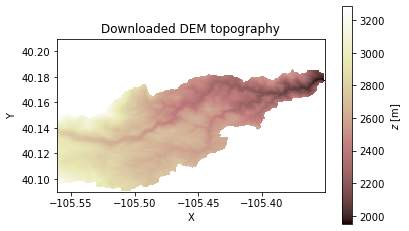

In [47]:
imshow_grid(
    grid_LL,
    "topographic__elevation",
    plot_name="Downloaded DEM topography",
    color_for_closed=None,
    colorbar_label="$z$ [m]",
)

## 2. Clip DEM to largest watershed using the FlowAccumulator and a watershed mask

Run the FlowAccumulator to determine where flow is being directed and accumulated in the watershed

In [5]:
fa_LL = FlowAccumulator(
    grid_LL, flow_director="D8", depression_finder="DepressionFinderAndRouter"
)
fa_LL.run_one_step()

### Create a mask to isolate the largest watershed:
Here we use the get_watershed_mask_with_area_threshhold function: https://landlab.readthedocs.io/en/master/reference/utils/watershed.html#landlab.utils.watershed.get_watershed_masks_with_area_threshold with a critical threshhold as the maximum drainage area. (This will filter out all watersheds draining to an area smaller than this.) 

In [6]:
mask = get_watershed_masks_with_area_threshold(grid_LL, grid_LL.at_node['drainage_area'].max())

Set all values outside the largest watershed to a nodata value of -9999:

In [7]:
no_dataval = -9999
grid_LL.at_node['topographic__elevation'] = np.where(mask != -1, grid_LL.at_node['topographic__elevation'], no_dataval)

Set the model boundary conditions to 'closed' outside of the watershed

In [46]:
grid_LL.status_at_node[np.isclose(grid_LL.at_node['topographic__elevation'], no_dataval)] = grid_LL.BC_NODE_IS_CLOSED

### Set a watershed boundary condition for your grid

This function uses the minimum elevation node nearest to the nodata values. This DEM only has one possible node, so it is easy for the function to determine. If an error is thrown that says 'Grid has multiple potential outlet nodes' choose one from the list of node IDs shown in the error window. (You may want to plot them on your DEM to verify that they make sense as an outlet node--see below). This error may happen when there are a few very low elevation cells.
* Note: this step is important for deliniating the channel. If you find the code is taking a long time to generate the NetworkModelGrid, check which node you set as the boundary condition.

Visualize clipped DEM:

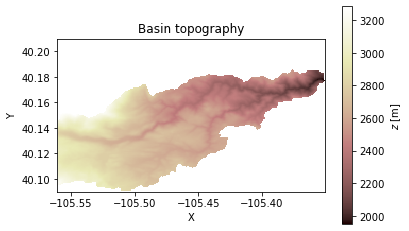

In [9]:
imshow_grid(
    grid_LL,
    "topographic__elevation",
    plot_name="Basin topography",
    color_for_closed=None,
    colorbar_label="$z$ [m]",
)

## 3. Create a NetworkModelGrid on this topography

Now we will generate a network using the default placement of a NetworkModelGrid node for every corresponding RasterModelGrid node. You may want to coarsen this later when you decide what is an acceptable NetworkModelGrid spacing for a NetworkSedimentTransporter model. (i.e. stability). Some notes:

* Be SURE you have a ballpark minimum channel threshhold: this is a drainage area threshhold that sets the upstream drainage area for which you want to truncate your channel network. Start high, and then reduce for a more complex network that extends to higher elevations.
* Be sure you have your outlet node defined
* You can pass information from the RasterModelGrid nodes to the NetworkModelGrid nodes using the 'include' variable if you have other things attached to your RasterModelGrid that would be helpful for the NetworkModelGrid to know (i.e. slope)

In [27]:
network_grid = network_grid_from_raster(
    grid_LL,
    minimum_channel_threshold=0.001,
    include=["drainage_area", "topographic__elevation"],
)

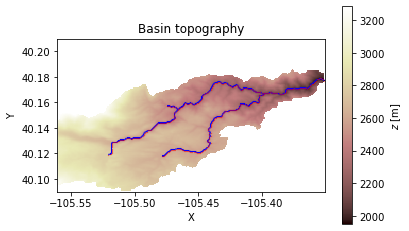

In [37]:
imshow_grid(
    grid_LL,
    "topographic__elevation",
    plot_name="Basin topography",
    color_for_closed=None,
    colorbar_label="$z$ [m]",
)
plot_links(network_grid, with_id=False, as_arrow=False, linewidth=0.05)
plot_nodes(network_grid, with_id=False, markersize=0.2)

### Refine Network using Reducers

Now we will use the Reducer options to reduce the number of nodes on the network. This shows an example where 10 nodes are placed on each segment of the river between bifurcations.

segments can be joined


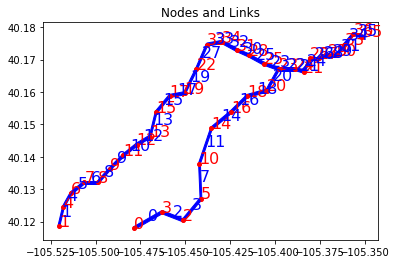

In [52]:
network_grid = network_grid_from_raster(
    grid_LL,
    reducer=AtMostNodes(count=10),
    minimum_channel_threshold=0.001,
    include=["drainage_area", "topographic__elevation"],
)

plot_nodes(network_grid, markersize=4)
plot_links(network_grid, as_arrow=False)
plt.title("Nodes and Links");

Realistically, you may want to reduce your NetworkModelGrid node spacing in the steeper, higher elevation areas of the basin for stability of the NetworkSedimentTransporter model. Here, we show an option to define the network node spacing from an upstream drainage area relation that estimates river width from the Frasson et al. 2019 (GRL) power law relationship:

$W=a*DA^b$

where $W$ is width $DA$ is drainage area and $a$ and $b$ are parameters. The function uses default values for a and b reported in the paper from fitting field data, but you  may want to adjust this depending on your river system. Changing n_widths will adjust node spacing by a certain multiple of local river width.

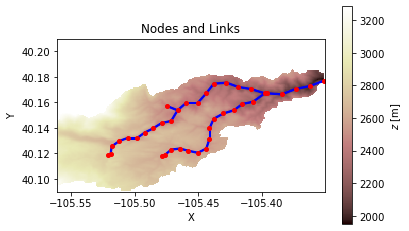

In [45]:
spacing = spacing_from_drainage_area(
    grid_LL.at_node["drainage_area"],
    a=9.68,
    b=0.32,
    n_widths=2
)


network_grid = network_grid_from_raster(
    grid_LL,
    reducer=SpacingAtLeast(grid_LL.xy_of_node, spacing),
    minimum_channel_threshold=0.001,
    include=["drainage_area", "topographic__elevation"],
)

imshow_grid(
    grid_LL,
    "topographic__elevation",
    plot_name="Basin topography",
    color_for_closed=None,
    colorbar_label="$z$ [m]",
)

plot_nodes(network_grid, with_id=False, markersize=4)
plot_links(network_grid, with_id=False, as_arrow=False)
plt.title("Nodes and Links");